# Transfer Learning
{{ badge }}

Transfer learning is a technique in deep learning where a pre-trained model, typically on a large dataset such as ImageNet, is used as a starting point for training a new model on a different but related task. The idea behind transfer learning is that the features learned by the pre-trained model can be useful for the new task, allowing us to train a new model with less data and computational resources.

One of the main benefits of transfer learning is that it can save a lot of time and resources, as the pre-trained model has already learned useful features from the large dataset. This means that we can use a pre-trained model as a starting point and fine-tune it for our specific task, rather than training a new model from scratch.

There are two main ways to use transfer learning in computer vision: feature extraction and fine-tuning. In feature extraction, we use the pre-trained model to extract features from our dataset and then train a new classifier on top of these features. In fine-tuning, we adjust the weights of the pre-trained model for our specific task by training the model on our dataset.

Transfer learning is especially useful when we have a small dataset or limited computational resources. It can also be useful when our task is similar to the task the pre-trained model was trained on. However, it's important to keep in mind that transfer learning may not be the best approach if our task is very different from the pre-trained model's task or if we have a large dataset.

## Table of Contents <a name="toc"></a>
* [Transfer Learning in TensorFlow](#tl_tf)
* [Preparing Dataset](#prep)
* [Building Model](#model)

## Transfer Learning in TensorFlow <a name="tl_tf"></a>
[Back to Top](#toc)


In TensorFlow/Keras, transfer learning is performed by using a pre-trained model as a feature extractor and then training a new model on top of the extracted features. The pre-trained model is typically a deep neural network that has already been trained on a large dataset, such as ImageNet.

To perform transfer learning, we first need to load the pre-trained model. This can be done using the `tf.keras.applications` module, which contains several pre-trained models for image classification tasks. For example, we can load the VGG16 model using the following code:

```python
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False)
```

The choice of paramteres here is important. The `weights` parameter specifies the type of weights to load. We can set this to `imagenet` to load the weights that were trained on the ImageNet dataset. We can also set this to `None` to load random weights. The `include_top` parameter specifies whether to include the fully-connected layer at the top of the network. We set this to `False` because we will be using the pre-trained model as a feature extractor and we don't need the classification layer.

When using a pretrained model we also need to use the same input processing steps that were used when the model was trained. For example, the VGG16 model was trained on images that were preprocessed using the `tf.keras.applications.vgg16.preprocess_input` function. We can use this function to preprocess our images before passing them to the model.

```python
x_train = tf.keras.applications.vgg16.preprocess_input(x_train)
x_test = tf.keras.applications.vgg16.preprocess_input(x_test)
```

## Preparing Dataset <a name="prep"></a>
[Back to Top](#toc)

We will be using the CIFAR-10 dataset to demonstrate the techniques for optimizing CNNs. The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# set random seeds for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
# load the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

170500096/170498071 [==============================] - 333s 2us/step
x_train shape: (50000, 32, 32, 3) y_train shape: (50000, 1)


In [4]:
# reshape the target
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

In [5]:
# create index labels dictionary
index_labels = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

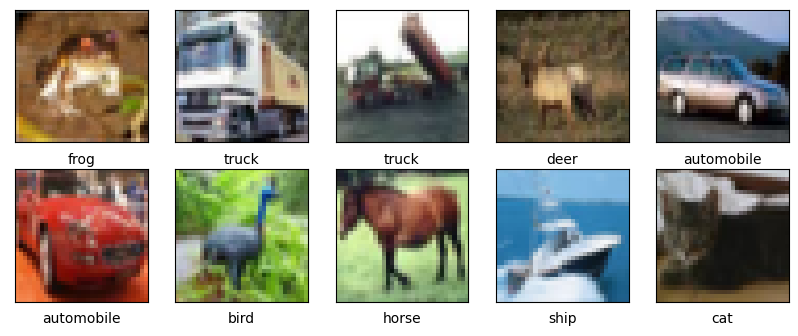

In [6]:
# plot the first 10 images in the training set and their labels
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(index_labels[y_train[i]])

In [7]:
# normalize the data using vgg16 preprocessing (if you use other models, you may need to use different preprocessing)
x_train = tf.keras.applications.vgg16.preprocess_input(x_train)
x_test = tf.keras.applications.vgg16.preprocess_input(x_test)

In [8]:
# one-hot encode the labels
y_train = tf.one_hot(y_train, depth=10)
y_test = tf.one_hot(y_test, depth=10)

2023-01-27 10:52:48.884605: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-27 10:52:48.889923: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


## Building Model <a name="model"></a>
[Back to Top](#toc)

We will use the VGG16 model as a feature extractor and then train a new classifier on top of the extracted features. The VGG16 model was trained on the ImageNet dataset, which contains 1.4 million images and 1000 classes. The input to the VGG16 model is expected to be 224x224 RGB images, which is different from the 32x32 images in the CIFAR-10 dataset. To solve this problem, we will utilize the `input_shape` parameter in VGG16 to specify the input size. We will also set `include_top` to `False` to remove the classification layer at the top of the network.

In [9]:
# load VGG16 model without the top layer while specifying the input shape
vgg16 = tf.keras.applications.vgg16.VGG16( input_shape=(32, 32, 3), include_top=False)
# note that we didn't explicitly specify the weights parameter since it uses imagenet weights by default.

# print the model summary
vgg16.summary()

58892288/58889256 [==============================] - 17s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_____________________________________________________________

In [10]:
# freeze the weights of the model
vgg16.trainable = False

# print the model summary, notice the number of trainable vs non-trainable parameters
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [11]:
# use the model as a layer in a new model
model = tf.keras.models.Sequential([
    vgg16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

# print the model summary, notice the number of trainable vs non-trainable parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 14,848,586
Trainable params: 133,898
Non-trainable params: 14,714,688
______________________________________

In [12]:
# compile the model
model.compile(
    optimizer= tf.keras.optimizers.Adam(),
    loss= tf.keras.losses.CategoricalCrossentropy(),
    metrics=[ tf.keras.metrics.CategoricalAccuracy()]
)

In [13]:
# create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5)

# train the model
history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping]
)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 351s 7ms/sample - loss: 4.2442 - categorical_accuracy: 0.3485 - val_loss: 1.5429 - val_categorical_accuracy: 0.4795
Epoch 2/100
50000/50000 [==============================] - 349s 7ms/sample - loss: 1.6543 - categorical_accuracy: 0.4187 - val_loss: 1.4025 - val_categorical_accuracy: 0.5458
Epoch 3/100
50000/50000 [==============================] - 350s 7ms/sample - loss: 1.5551 - categorical_accuracy: 0.4569 - val_loss: 1.2923 - val_categorical_accuracy: 0.5797
Epoch 4/100
44800/50000 [=========================>....] - ETA: 30s - loss: 1.5311 - categorical_accuracy: 0.4723